### imports 

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['font.size'] = 14
plt.rcParams['lines.linewidth'] = 2

In [3]:
from tqdm.notebook import tqdm_notebook

In [4]:
import io
import requests 
import pathlib

In [5]:
import xarray as xr
from cartopy import crs as ccrs
from dask.distributed import Client, LocalCluster
from dask.diagnostics import ProgressBar

In [6]:
import numpy as np 
import pandas as pd

In [7]:
cluster = LocalCluster(
    n_workers=6,
    threads_per_worker=1,
    memory_limit="4GiB",
    processes=True,
)

client = Client(cluster)

In [8]:
client 

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 6
Total threads: 6,Total memory: 24.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39965,Workers: 6
Dashboard: http://127.0.0.1:8787/status,Total threads: 6
Started: Just now,Total memory: 24.00 GiB
Comm: tcp://127.0.0.1:33077,Total threads: 1
Dashboard: http://127.0.0.1:34069/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:46285,


### Monthly NCEP / NCAR reanalysis, via HTTPS 

In [9]:
url = 'https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis.derived/surface/air.mon.mean.nc'

In [10]:
with requests.get(url) as r:
    dset = xr.open_dataset(io.BytesIO(r.content))

In [11]:
dset

<xarray.Dataset>
Dimensions:  (lat: 73, lon: 144, time: 892)
Coordinates:
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2022-04-01
Data variables:
    air      (time, lat, lon) float32 ...
Attributes:
    description:    Data from NCEP initialized reanalysis (4x/day).  These ar...
    platform:       Model
    Conventions:    COARDS
    NCO:            20121012
    history:        Thu May  4 20:11:16 2000: ncrcat -d time,0,623 /Datasets/...
    title:          monthly mean air.sig995 from the NCEP Reanalysis
    dataset_title:  NCEP-NCAR Reanalysis 1
    References:     http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis...

In [12]:
dset.close()

### OpenDAP protocol, served by the PSL Thredds server 

see catalog: [https://psl.noaa.gov/thredds/catalog/Datasets/catalog.html](https://psl.noaa.gov/thredds/catalog/Datasets/catalog.html)

In [13]:
url = 'https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis.derived/surface/air.mon.mean.nc'

In [14]:
dset = xr.open_dataset(url)

In [15]:
dset

<xarray.Dataset>
Dimensions:  (lon: 144, time: 892, lat: 73)
Coordinates:
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2022-04-01
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
Data variables:
    air      (time, lat, lon) float32 ...
Attributes:
    description:                     Data from NCEP initialized reanalysis (4...
    platform:                        Model
    Conventions:                     COARDS
    NCO:                             20121012
    history:                         Thu May  4 20:11:16 2000: ncrcat -d time...
    title:                           monthly mean air.sig995 from the NCEP Re...
    dataset_title:                   NCEP-NCAR Reanalysis 1
    References:                      http://www.psl.noaa.gov/data/gridded/dat...
    DODS_EXTRA.Unlimited_Dimension:  time

In [16]:
dset.close()

### dataset split between multiple files: daily reanalyses via OpenDAP

see: [https://psl.noaa.gov/thredds/catalog/Datasets/ncep.reanalysis.dailyavgs/surface/catalog.html](https://psl.noaa.gov/thredds/catalog/Datasets/ncep.reanalysis.dailyavgs/surface/catalog.html)

each file has the pattern: 

`https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis.dailyavgs/surface/air.sig995.YYYY.nc`

In [17]:
dset = xr.open_dataset('https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis.dailyavgs/surface/air.sig995.2000.nc')

In [18]:
dset

<xarray.Dataset>
Dimensions:  (lon: 144, time: 366, lat: 73)
Coordinates:
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-12-31
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
Data variables:
    air      (time, lat, lon) float32 ...
Attributes:
    Conventions:                     COARDS
    title:                           mean daily NMC reanalysis (2000)
    description:                     Data is from NMC initialized reanalysis\...
    platform:                        Model
    history:                         created 00/01/30 by Hoop (netCDF2.3)\nCo...
    dataset_title:                   NCEP-NCAR Reanalysis 1
    References:                      http://www.psl.noaa.gov/data/gridded/dat...
    DODS_EXTRA.Unlimited_Dimension:  time

In [19]:
dset.close()

#### create a list of URLs 

In [20]:
base_url = 'https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis.dailyavgs/surface/air.sig995'

In [21]:
list_files = [f'{base_url}.{year}.nc' for year in range(2010, 2021)]

In [22]:
list_files

['https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis.dailyavgs/surface/air.sig995.2010.nc',
 'https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis.dailyavgs/surface/air.sig995.2011.nc',
 'https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis.dailyavgs/surface/air.sig995.2012.nc',
 'https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis.dailyavgs/surface/air.sig995.2013.nc',
 'https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis.dailyavgs/surface/air.sig995.2014.nc',
 'https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis.dailyavgs/surface/air.sig995.2015.nc',
 'https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis.dailyavgs/surface/air.sig995.2016.nc',
 'https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis.dailyavgs/surface/air.sig995.2017.nc',
 'https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis.dailyavgs/surface/air.sig995.2018.nc',
 'https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis.dailyavgs/surface/air.sig995.

### open a `multiple file` dataset

In [23]:
dset = xr.open_mfdataset(list_files, parallel=True, chunks=dict(time='500Mb'))

In [24]:
dset = dset.drop('time_bnds')

In [25]:
dset.nbytes / 1e9

0.168981876

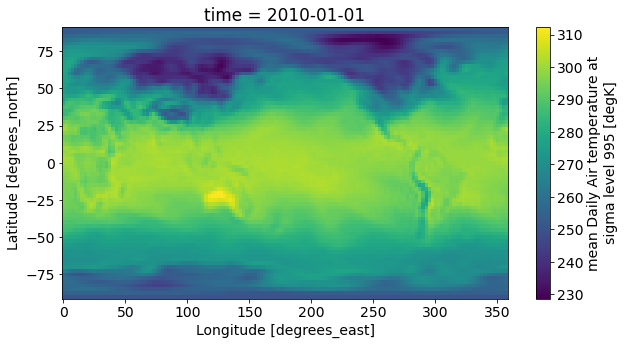

In [26]:
dset['air'].isel(time=0).plot()

## conversion from Kelvin to Celsius is handled easily 

In [27]:
dset['air'] = dset['air'] - 273.15

# or 

# dset['air'] -= 273.15


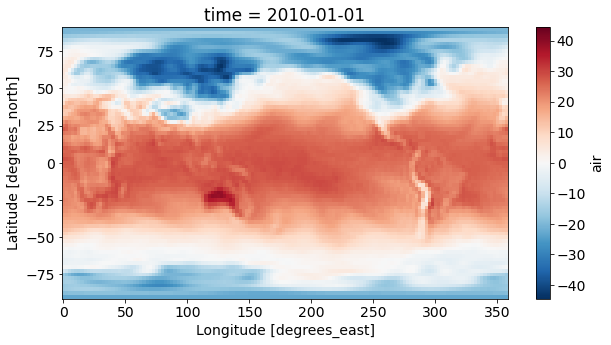

In [28]:
dset['air'].isel(time=0).plot()

### calculating the time mean 

In [29]:
dset = dset.chunk({'time':-1, 'lat':10, 'lon':10})

In [30]:
dset_ave = dset.mean('time')

In [31]:
with ProgressBar(): 
    dset_ave.compute() 

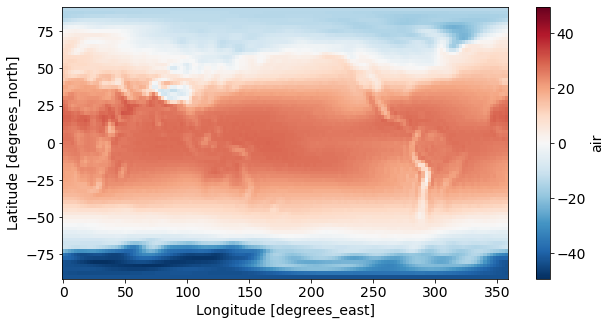

In [32]:
dset_ave['air'].plot()

In [33]:
dset_ave.close()
dset.close()

-----

### ERA5 via OpenDAP on the Asia Pacific Data Research Center 

start at http://apdrc.soest.hawaii.edu/data/data.php

### monthly aggregated variables 

In [34]:
url = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/Reanalysis_Data/ERA5/monthly_2d/Surface'

In [35]:
dset = xr.open_dataset(url)

/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/xarray/coding/times.py:144: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


In [36]:
dset

<xarray.Dataset>
Dimensions:  (time: 520, lat: 721, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2022-04-01
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
Data variables:
    u10      (time, lat, lon) float32 ...
    v10      (time, lat, lon) float32 ...
    t2m      (time, lat, lon) float32 ...
    iews     (time, lat, lon) float32 ...
    inss     (time, lat, lon) float32 ...
    msl      (time, lat, lon) float32 ...
    skt      (time, lat, lon) float32 ...
    sp       (time, lat, lon) float32 ...
    sst      (time, lat, lon) float32 ...
    tp       (time, lat, lon) float32 ...
Attributes:
    title:          ERA5 monthly averaged reanalysis single level variables
    Conventions:    COARDS\nGrADS
    dataType:       Grid
    documentation:  http://apdrc.soest.hawaii.edu/datadoc/ecmwf_ERA5.php
    history:        Sun May 15 17:33:11 HST 2022 : imported by GrADS Data Ser...

### we can just extract the variable of interest 

In [37]:
dset = xr.open_dataset(url)[['t2m']]

In [38]:
dset.nbytes / 1e9

2.159560648

In [39]:
dset

<xarray.Dataset>
Dimensions:  (time: 520, lat: 721, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2022-04-01
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
Data variables:
    t2m      (time, lat, lon) float32 ...
Attributes:
    title:          ERA5 monthly averaged reanalysis single level variables
    Conventions:    COARDS\nGrADS
    dataType:       Grid
    documentation:  http://apdrc.soest.hawaii.edu/datadoc/ecmwf_ERA5.php
    history:        Sun May 15 17:33:11 HST 2022 : imported by GrADS Data Ser...

In [40]:
dset.close()

### daily aggregated variables 

- [http://apdrc.soest.hawaii.edu/dods/public_data/Reanalysis_Data/ERA5/daily_3d](http://apdrc.soest.hawaii.edu/dods/public_data/Reanalysis_Data/ERA5/daily_3d)

air temperature: 

- [http://apdrc.soest.hawaii.edu:80/dods/public_data/Reanalysis_Data/ERA5/daily_3d/Air_Temperature](http://apdrc.soest.hawaii.edu:80/dods/public_data/Reanalysis_Data/ERA5/daily_3d/Air_Temperature)



In [41]:
url = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/Reanalysis_Data/ERA5/daily_3d/Air_Temperature'

In [42]:
dset = xr.open_dataset(url)

In [43]:
dset

<xarray.Dataset>
Dimensions:      (time: 15826, lev: 27, lat: 721, lon: 1440)
Coordinates:
  * time         (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2022-04-30
  * lev          (lev) float64 100.0 125.0 150.0 175.0 ... 950.0 975.0 1e+03
  * lat          (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * lon          (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
Data variables:
    temperature  (time, lev, lat, lon) float32 ...
Attributes:
    title:          ERA5 daily averaged reanalysis Air Temperature
    Conventions:    COARDS\nGrADS
    dataType:       Grid
    documentation:  http://apdrc.soest.hawaii.edu/datadoc/ecmwf_ERA5.php
    history:        Thu May 05 22:49:48 HST 2022 : imported by GrADS Data Ser...

In [44]:
dset.nbytes / 1e9

1774.568258032

In [45]:
dset.lev

<xarray.DataArray 'lev' (lev: 27)>
array([ 100.,  125.,  150.,  175.,  200.,  225.,  250.,  300.,  350.,  400.,
        450.,  500.,  550.,  600.,  650.,  700.,  750.,  775.,  800.,  825.,
        850.,  875.,  900.,  925.,  950.,  975., 1000.])
Coordinates:
  * lev      (lev) float64 100.0 125.0 150.0 175.0 ... 925.0 950.0 975.0 1e+03
Attributes:
    grads_dim:      z
    grads_mapping:  levels
    units:          millibar
    long_name:      altitude
    minimum:        100.0
    maximum:        1000.0
    resolution:     34.615383

In [46]:
dset = dset.sel(lev=1000., lat=slice(-90., 30.))

In [47]:
dset.nbytes / 1e9

43.847024544

### we are going to save the 1st 5 days worth of data to disk 

In [48]:
opath = pathlib.Path('../data/ERA5/temperature')

In [49]:
if not(opath.exists()): 
    print(f"{str(opath)} does not exist, creating ...")
    opath.mkdir(parents=True)

In [50]:
for t in tqdm_notebook(dset.time.to_index()[:5]): 
    sub = dset.sel(time=t)
    sub.expand_dims({'time':[t]})
    sub.to_netcdf(opath.joinpath(f'./ERA5_temp_{t:%Y-%m-%d}.nc'))
    sub.close()

  0%|          | 0/5 [00:00<?, ?it/s]

Error:curl error: Timeout was reached
curl error details: 


OSError: [Errno -68] NetCDF: I/O failure: b'http://apdrc.soest.hawaii.edu:80/dods/public_data/Reanalysis_Data/ERA5/daily_3d/Air_Temperature'

In [ ]:
dset.close()

### list the local files 

In [51]:
lfiles = list(opath.glob("ERA5_temp_*.nc"))

In [52]:
lfiles.sort()

In [53]:
lfiles

[PosixPath('../data/ERA5/temperature/ERA5_temp_1979-01-01.nc'),
 PosixPath('../data/ERA5/temperature/ERA5_temp_1979-01-02.nc'),
 PosixPath('../data/ERA5/temperature/ERA5_temp_1979-01-03.nc'),
 PosixPath('../data/ERA5/temperature/ERA5_temp_1979-01-04.nc'),
 PosixPath('../data/ERA5/temperature/ERA5_temp_1979-01-05.nc')]

In [54]:
dset = xr.open_mfdataset(lfiles, concat_dim='time', combine='nested')

In [55]:
dset

<xarray.Dataset>
Dimensions:      (time: 5, lat: 481, lon: 1440)
Coordinates:
  * time         (time) datetime64[ns] 1979-01-01 1979-01-02 ... 1979-01-05
    lev          float64 1e+03
  * lat          (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 29.5 29.75 30.0
  * lon          (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
Data variables:
    temperature  (time, lat, lon) float32 dask.array<chunksize=(1, 481, 1440), meta=np.ndarray>
Attributes:
    title:          ERA5 daily averaged reanalysis Air Temperature
    Conventions:    COARDS\nGrADS
    dataType:       Grid
    documentation:  http://apdrc.soest.hawaii.edu/datadoc/ecmwf_ERA5.php
    history:        Thu May 05 22:49:48 HST 2022 : imported by GrADS Data Ser...

### convert to Celsius 

In [56]:
dset['temperature'] -= 273.15

### re-chunk, we want one chunk along the time dimension only as we are going to calculate the time mean 

In [57]:
dset.chunks

Frozen({'time': (1, 1, 1, 1, 1), 'lat': (481,), 'lon': (1440,)})

In [58]:
dset = dset.chunk({'time':-1, 'lat':10, 'lon':10})

In [59]:
dset.chunks

Frozen({'time': (5,), 'lat': (10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1), 'lon': (10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10)})

In [60]:
dset = dset.mean('time')

In [61]:
dset.compute()

<xarray.Dataset>
Dimensions:      (lat: 481, lon: 1440)
Coordinates:
    lev          float64 1e+03
  * lat          (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 29.5 29.75 30.0
  * lon          (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
Data variables:
    temperature  (lat, lon) float32 -6.223 -6.223 -6.223 ... 20.29 20.17 20.06

### proper map with coastlines, using cartopy 

In [62]:
cbar_kwargs = dict(shrink=0.5, orientation='horizontal', pad=0.01)

Text(0.5, 1.0, 'ERA5 temperature at 1000 hPa')

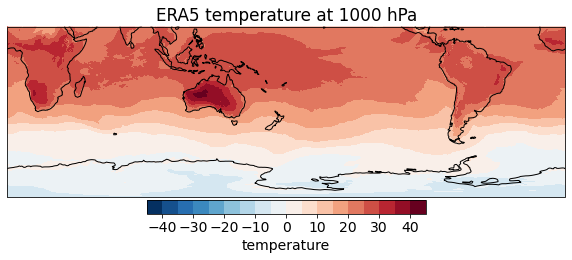

In [63]:
f, ax = plt.subplots(subplot_kw={"projection":ccrs.PlateCarree(central_longitude=180)})
dset['temperature'].plot(ax=ax, levels=20, transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs)
ax.coastlines()
ax.set_extent([0, 360, -90, 20], crs=ccrs.PlateCarree())
ax.set_title('ERA5 temperature at 1000 hPa')

In [64]:
cbar_kwargs.update(dict(orientation='vertical', shrink=0.7))

Text(0.5, 1.0, 'ERA5 temperature at 1000 hPa')

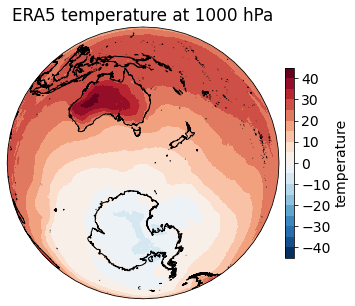

In [65]:
f, ax = plt.subplots(subplot_kw={"projection":ccrs.Orthographic(central_longitude=150, central_latitude=-55)})
dset['temperature'].plot(ax=ax, levels=20, transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs)
ax.coastlines(resolution='10m')
ax.set_title('ERA5 temperature at 1000 hPa')

In [66]:
dset.close()